## Challenge Overview

The challenge focuses on NLP to discern tweets that report real disasters from those that do not. With the proliferation of smartphones, individuals often report emergencies in real-time on platforms like Twitter. Distinguishing between actual disaster reports and metaphorical or non-disaster-related posts can be challenging for automated systems. This competition aims to create machine learning models capable of making distinction, using a dataset of 10,000 tweets that have been manually classified as either disaster-related or not. 

## Data Description

The dataset comprises tweets with various pieces of information: 

* **Text**: The content of the tweet. 
* **Keyword**: A keyword extracted from the tweet (may be blank).
* **Location**: The location from which the tweet was sent (may also be blank).
* **Target**: A binary label indicating whether the tweet is about a real disaster (```1```) or not (```0```). This label is only available in the training set.

#### Files: 

* ```train.csv```: Contains the training data ```text```, ```keyword```, ```location```, and ```target``` columns.
* ```test.csv```: Contains the test data without the ```target``` column.
* ```sample_submission.csv```: An example submission file in the corrected format.

#### Dataset Statistics: 

* The dataset contains 10,000 tweets divided into training and test sets. 
* The ```id``` column uniquely identifies each tweet. 
* The distribution of tweets across different labels (```0``` for non-disaster and ```1``` for disaster) is balanced in the training set, although specific counts were not provided. 
* Keywords and locations may be missing for some tweets, indicating the presence of missing data that models will need to handle. 

#### Evaluation Metric: 

* Submissions are evaluated using the F1 score, which is a balance between precision (the accuracy of positive predictions) and recall (the ability to find all positive instances). The F1 score is particularly suitable for datasets with imbalanced classes, though it was mentioned that this dataset is balanced.

## Data Structure and Size

* The dataset is structured in CSV format, with separate files for training, testing, and submission examples.
* Each tweet's data is a row in the respective CSV file, with columns for ```id```, ```text```, ```keyword```, ```location```, and ```target``` (the last only in ```train.csv```). 
* The exact size of the dataset is 421 KB for ```test.csv``` and 988 KB for ```train.csv```.

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from keras_tuner import HyperModel, RandomSearch
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.regularizers import L2
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [39]:
class LSTMHyperModel(HyperModel): 
    def __init__(self, max_length, vocab_size): 
        self.max_length = max_length
        self.vocab_size = vocab_size

    def build(self, hp): 
        model = keras.Sequential()
        model.add(Embedding(input_dim = self.vocab_size + 1, output_dim = hp.Choice('embedding_output_dim', [50, 100, 200]), input_length = self.max_length))
        model.add(LSTM(units = hp.Int('units', min_value = 32, max_value = 512, step = 32), dropout = hp.Float('dropout', 0, 0.5, step = 0.1), return_sequences = False))

        learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling = 'log')
        model.compile(optimizer = keras.optimizers.Adam(learning_rate = learning_rate), loss = 'binary_crossentropy', metrics = ['accuracy'])
        return model

For the EDA of our dataset containing tweets related to real and non-real disasters, we should follow a structured approach that includes data inspection, visualization, cleaning, and outlining a plan of analysis. The primary goal is to understand the data's characteristics, identify any anomalies or patterns, and prepare the data for modeling. Below, I am going to outline the steps and procedures I will take for such an analysis, focusing on the tweet text, keywords, locations, and binary targets indicating whether a tweet is about a real disaster.

## Data Inspection

1. **Load the Data**: Import the dataset using pandas library.
2. **Initial Overview**: Utilize methods to get a basic understanding of the dataset structure.

In [7]:
# Load the datasets 
train_data = pd.read_csv('/Users/calebwhite/Downloads/nlp-getting-started/train.csv')
test_data = pd.read_csv('/Users/calebwhite/Downloads/nlp-getting-started/test.csv')

In [8]:
# Display the first few rows of the training data
print(train_data.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [9]:
# Get information on the data structure
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [10]:
# Get statistical summaries of the numerical columns
train_data.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


Based on the initial data inspection, we will now proceed to visualize the dataset.

## Data Visualization

To visualize the dataset: 

1. **Target Variable Distribution**: Use a bar chart to visualize the distribution of the ```target``` variable to understand the balance between disaster and non-disaster tweets.
2. **Keyword Frequency**: A histogram or bar chart showing the most common keywords could reveal particular words often associated with either real or non-real disasters.
3. **Tweet Length Distribution**: Plot the distribution of tweet lengths.
4. **Word Clouds**: Generate word clouds for both classes.

In [11]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plot the distribution of the target variable
plt.figure(figsize = (6, 4))
sns.countplot(x = 'target', data = train_data)
plt.title('Distribution of Disaster (1) vs. Non-Disaster (0) Tweets')
plt.xlabel('Disaster Tweet')
plt.ylabel('Count')
plt.show()

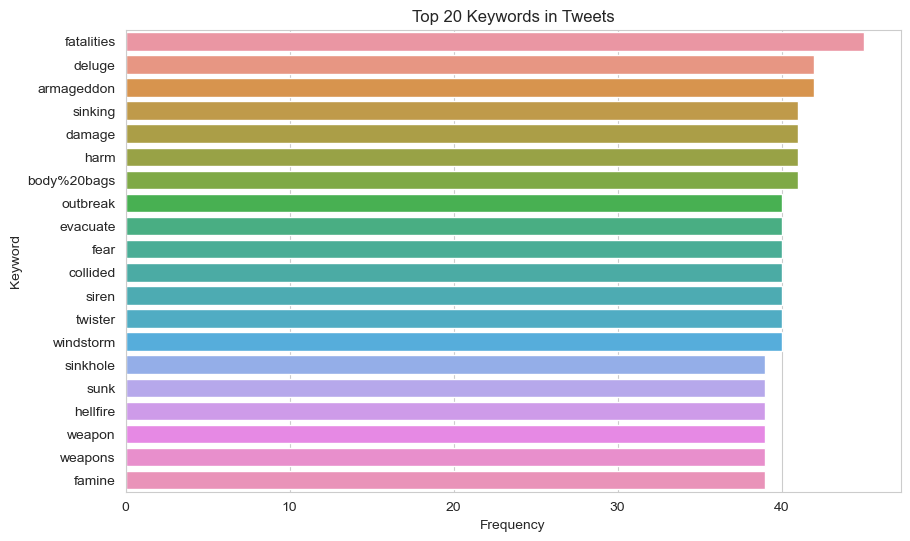

In [12]:
plt.figure(figsize = (10, 6))
sns.countplot(y = 'keyword', data = train_data, order = train_data['keyword'].value_counts().index[:20])
plt.title('Top 20 Keywords in Tweets')
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.show()

In [13]:
# Create a new column for tweet length
train_data['tweet_length'] = train_data['text'].apply(len)

/Users/calebwhite/opt/anaconda3/envs/tensor/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/calebwhite/opt/anaconda3/envs/tensor/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/calebwhite/opt/anaconda3/envs/tensor/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/calebwhite/

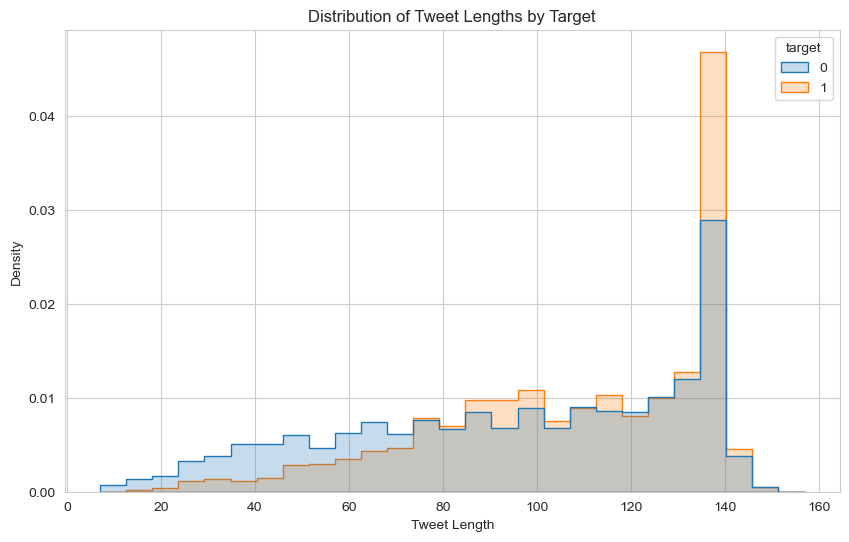

In [14]:
# Plot the distribution of tweet lengths
plt.figure(figsize = (10, 6))
sns.histplot(data = train_data, x = 'tweet_length', hue = 'target', element = 'step', stat = 'density', common_norm = False)
plt.title('Distribution of Tweet Lengths by Target')
plt.xlabel('Tweet Length')
plt.ylabel('Density')
plt.show()

In [15]:
# Generate a word cloud for disaster tweets
disaster_tweets = ' '.join(text for text in train_data[train_data['target'] == 1]['text'])
disaster_wordcloud = WordCloud(max_font_size = 100, max_words = 100, background_color = "white").generate(disaster_tweets)

In [16]:
# Generate a word cloud for non-disaster tweets
non_disaster_tweets = ' '.join(text for text in train_data[train_data['target'] == 0]['text'])
non_disaster_wordcloud = WordCloud(max_font_size = 100, max_words = 100, background_color = "white").generate(non_disaster_tweets)

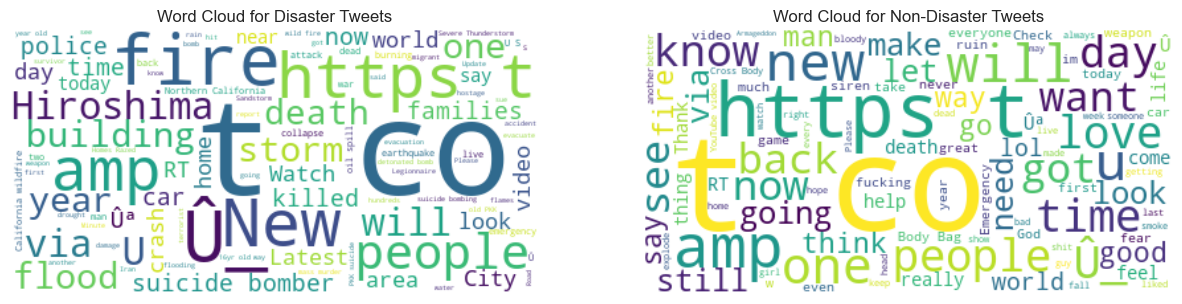

In [17]:
# Display the word clouds
plt.figure(figsize = (15, 7))
plt.subplot(1, 2, 1)
plt.imshow(disaster_wordcloud, interpolation = 'bilinear')
plt.title('Word Cloud for Disaster Tweets')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(non_disaster_wordcloud, interpolation = 'bilinear')
plt.title('Word Cloud for Non-Disaster Tweets')
plt.axis('off')
plt.show()

The visualizations illustrate the key aspects of the data.

## Data Cleaning

We will now handle missing values for 'keyword' and 'location'.

## For 'keyword': 
* There are relatively few mssing 'keyword' values.

## For 'location': 
* There are a larger number of missing 'location' values and it would be too complex to accurately impute these so considering that it would not significantly contribute to predictive accuracy, this feature will be excluded from the model.

In [18]:
# Fill missing 'keyword'
train_data['keyword'].fillna('unknown', inplace = True)

# I don't think 'location' will be important for the modeling
train_data.drop(columns = ['location'], inplace = True)

/var/folders/r6/z79hyk110tx6h7k60sklwdhw0000gn/T/ipykernel_47418/2711697878.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['keyword'].fillna('unknown', inplace = True)


## Model Architecture

For the Natural Language Processing task of classifying tweets as related to real disasters or not, the most effective approach would be to use a RNN architecture. RNNs are suitable for sequence data such as text because they can process input sequences of varying lengths and maintain an internal state that captures the context of words in a sequence.

Vanilla RNNs are prone to vanishing and exploding gradient problems when dealing with long sequences. Therefore, more advanced variants like LSTMs or GRUs are preferable because they are designed to remember long-term dependencies while mitigating these issues. 

An LSTM would be particularly suitable for this task due to its ability to capture dependencies for sequences of words in tweets, which is critical in understanding the context that differentiates a real disaster from a metaphorical expression.

The model architecture will look like this: 

1. **Embedding Layer**: This will convert word indices into dense vectors of a fixed size. It is the first layer of the model, where each word is represented as a dense vector that is learned during training. 
2. **LSTM Layer**: The LSTM layer processes the sequence of word embeddings. It has memory cells that store and output information, which allows it to capture temporal dependencies.
3. **Dense Layer**: Following the LSTM, a dense layer can interpret the features extracted by the RNN layer. 
4. **Output Layer**: A final dense layer with a single neuron and a sigmoid activation function to output a probability that the tweet is about a real disaster.

## Word Embedding

Word embeddings are a type of word representation that allows words with similar meaning to have a similar representation. For this task, we can use TF-IDF as out strategy to convert raw texts to word embeddings.

In [19]:
# Preprocessing text for the model
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['text'])
sequences = tokenizer.texts_to_sequences(train_data['text'])
word_index = tokenizer.word_index

In [20]:
# Pad sequences to ensure uniform length
max_length = max(len(s) for s in sequences)
tweet_pad = pad_sequences(sequences, maxlen = max_length, padding = 'post')

In [21]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(tweet_pad, train_data['target'], test_size = 0.2, random_state = 42)

In [22]:
# Create TF-IDF representation
tfidf = TfidfVectorizer(max_features = len(word_index) + 1, use_idf = True)
tfidf.fit(train_data['text'])
X_train_tfidf = tfidf.transform(train_data['text']).toarray()

In [24]:
# Define the model
model = Sequential()
model.add(Embedding(input_dim = len(word_index) + 1, output_dim = 50, input_length = max_length))
model.add(LSTM(units = 64, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(units = 1, activation = 'sigmoid'))

In [25]:
# Compile the model
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])

In [26]:
# Train the model
history = model.fit(X_train, y_train, batch_size = 32, epochs = 10, validation_data = (X_val, y_val), verbose = 1)

Epoch 1/10
191/191 [==============================] - 5s 18ms/step - loss: 0.5537 - accuracy: 0.7100 - val_loss: 0.4544 - val_accuracy: 0.8076
Epoch 2/10
191/191 [==============================] - 3s 16ms/step - loss: 0.3041 - accuracy: 0.8790 - val_loss: 0.5066 - val_accuracy: 0.7905
Epoch 3/10
191/191 [==============================] - 3s 17ms/step - loss: 0.1557 - accuracy: 0.9461 - val_loss: 0.5137 - val_accuracy: 0.7715
Epoch 4/10
191/191 [==============================] - 3s 16ms/step - loss: 0.0971 - accuracy: 0.9683 - val_loss: 0.8526 - val_accuracy: 0.7551
Epoch 5/10
191/191 [==============================] - 3s 17ms/step - loss: 0.0701 - accuracy: 0.9801 - val_loss: 0.6709 - val_accuracy: 0.7735
Epoch 6/10
191/191 [==============================] - 3s 16ms/step - loss: 0.0401 - accuracy: 0.9903 - val_loss: 0.9961 - val_accuracy: 0.7538
Epoch 7/10
191/191 [==============================] - 3s 16ms/step - loss: 0.0350 - accuracy: 0.9918 - val_loss: 0.8449 - val_accuracy: 0.7511

The output from training the LSTM model shows the training and validation loss and accuracy over 10 epochs. Here's an interpretation of the training process: 

* **Training Loss and Accuracy**: The training loss decreases from 0.5537 to 0.0212, and the training accuracy increases from 0.7100 to 0.9951. This indicates that the model is learning and performing well on the training data.
* **Validation Loss and Accuracy**: The validation loss initially decreases, but from epoch 4 onwards, it starts to increase, while the validation accracy peaks at epoch 1 and then decreases. This is a classic sign of overfitting, where the model performs increasingly well on the training data but worse on the unseen validation data.

The increasing validation loss and fluctuating validation accuracy suggest that the model has memorized the training data to a certain extent, and it's not generlaizing well to new, unseen data. This is a common challenge in machine learning and deep learning models, especially with text data where the model might latch onto noise or non-generalization patterns in the training set.

To address overfitting we will follow: 

1. **Regularization**: Apply L1 or L2 regularization in the LSTM and dense layers to penalize large weights.

In [28]:
# Define the model with L2 regularization
model = Sequential()
model.add(Embedding(input_dim = len(word_index) + 1, output_dim = 50, input_length = max_length))

In [29]:
# Add L2 regularization to the LSTM layer
model.add(LSTM(units = 64, dropout = 0.2, recurrent_dropout = 0.2, kernel_regularizer = L2(0.01)))

In [30]:
# Add L2 regularization to the Dense layer
model.add(Dense(units = 1, activation = 'sigmoid', kernel_regularizer = L2(0.01)))

In [31]:
# Compile the model
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])

In [32]:
# Train the model with same training data and parameters
history = model.fit(X_train, y_train, batch_size = 32, epochs = 10, validation_data = (X_val, y_val), verbose = 1)

Epoch 1/10
191/191 [==============================] - 5s 18ms/step - loss: 0.7835 - accuracy: 0.6810 - val_loss: 0.4921 - val_accuracy: 0.7965
Epoch 2/10
191/191 [==============================] - 3s 17ms/step - loss: 0.3678 - accuracy: 0.8686 - val_loss: 0.4999 - val_accuracy: 0.8030
Epoch 3/10
191/191 [==============================] - 3s 17ms/step - loss: 0.2204 - accuracy: 0.9346 - val_loss: 0.6657 - val_accuracy: 0.7807
Epoch 4/10
191/191 [==============================] - 3s 16ms/step - loss: 0.1517 - accuracy: 0.9611 - val_loss: 0.6076 - val_accuracy: 0.7794
Epoch 5/10
191/191 [==============================] - 3s 16ms/step - loss: 0.1099 - accuracy: 0.9744 - val_loss: 0.6594 - val_accuracy: 0.7774
Epoch 6/10
191/191 [==============================] - 3s 17ms/step - loss: 0.0969 - accuracy: 0.9805 - val_loss: 0.6950 - val_accuracy: 0.7597
Epoch 7/10
191/191 [==============================] - 3s 17ms/step - loss: 0.0925 - accuracy: 0.9782 - val_loss: 0.8678 - val_accuracy: 0.7702

The updated model training output with L2 regularization shows the following: 

* **Training Loss and Accuracy**: The model starts with a higher initial loss, which is expected due to the regularization penalty being added to the loss. The training loss decreases from 0.7835 to 0.0750, and the training accuracy improves significantly from 0.6810 to 0.9869, indicating good learning on the training set.
* **Validation Loss and Accuracy**: The validation loss is initially lower compared to the model without regularization but begins to increase after the second epoch, suggesting that overfitting may still be occuring. The validation accuracy starts strong but soesn't improve significantly over time.

Although L2 regularization helps in mitgating overfitting by penalizing large weights, the model still overfits as indicated by the increasing validation loss and plateauing validation accuracy. This suggests that while L2 regularization has added some bias to the model, it may not be sufficient by iteself to prevent overfitting. 

To further reduce overfitting we will try: 

2. **Early Stopping**: Stop training when the validation loss starts to increase, to prevent the model from learning noise in the training data.

In [34]:
# Define the early stopping callback
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 2, verbose = 1, restore_best_weights = True)

# Train the model with early stopping
history = model.fit(
    X_train, y_train, 
    batch_size = 32, 
    epochs = 10, 
    validation_data = (X_val, y_val), 
    ## Including the early stopping callback here
    callbacks = [early_stopping], 
    verbose = 1
)

Epoch 1/10
191/191 [==============================] - 3s 17ms/step - loss: 0.0720 - accuracy: 0.9869 - val_loss: 0.8588 - val_accuracy: 0.7663
Epoch 2/10
191/191 [==============================] - 3s 17ms/step - loss: 0.0614 - accuracy: 0.9901 - val_loss: 0.8057 - val_accuracy: 0.7689
Epoch 3/10
191/191 [==============================] - 3s 16ms/step - loss: 0.0550 - accuracy: 0.9916 - val_loss: 0.9392 - val_accuracy: 0.7722
Epoch 4/10
191/191 [==============================] - 3s 16ms/step - loss: 0.0601 - accuracy: 0.9900 - val_loss: 0.6970 - val_accuracy: 0.7636
Epoch 5/10
191/191 [==============================] - 3s 17ms/step - loss: 0.0663 - accuracy: 0.9893 - val_loss: 0.7738 - val_accuracy: 0.7649
Epoch 6/10
191/191 [==============================] - 3s 17ms/step - loss: 0.0658 - accuracy: 0.9897 - val_loss: 0.8643 - val_accuracy: 0.7518
Epoch 6: early stopping


The implementation of early stopping in our model training process appears to have worked effectively. Early stopping is used to halt the training when the model begins to overfit, or when a monitored metric has stopped improving. In this case, it seems that the training process was stopped after the 6th epoch because the validation loss began to increase, which is a sign that the model might not be generalizing well to unseen data. 

Here's an interpretation of what the model training logs indicate: 

* **Early Stopping Trigger**: The early stopping callback monitored the validation loss and stopped training at epoch 6. It also restored the weights from the best epoch, which is epoch 4 in this case. This means that while the model's accuracy on the training set continued to improve, the validation loss started to rise after the 4th epoch, triggering the early stopping.
* **Validation Loss and Accuracy**: The best validation loss was achieved at epoch 4 with a loss of 0.6970, and an accuracy of 0.7636. Subsequent epochs did not improve on this, indicating that epoch 4 provided the model with the best generalization performance on the validation set.
* **Model Generalization**: With the weights restored to those of the best epoch, the model is now set up to potentially generalize better to new, unseen data compared to if training had continued beyond the point of overfitting.

Using early stopping is a good practice to prevent overfitting, especially when the training data might not fully represent the complexity of unseen data. We may want to consider running several training runs with different random initializations to ensure stability of the results, as somtimes early stopping can lead to slightly different models if the validation loss fluctuates close to the stopping point.

For the results and analysis section, we'll discuss a structured approach to hyperparameter tuning, experimenting with different architectures, applying techniques to improve training and performance, and analyzing the results.

## Hyperparameter Tuning 

Hyperparameter tuning involves experimenting with various values for the model's hyperparameters to improve performance. Common hyperparameters to tune in an LSTM model include: 

* Number of LSTM units
* Number of LSTM layers
* Droupout rate
* Learning rate
* Batch size
* Embedding vector size

In [42]:
hypermodel = LSTMHyperModel(max_length = max_length, vocab_size = len(word_index))

tuner = RandomSearch(
    hypermodel, 
    objective = 'val_accuracy', 
    max_trials = 5, 
    executions_per_trial = 1, 
    directory = 'lstm_tuning', 
    project_name = 'disaster_tweet_classification'
)

tuner.search(X_train, y_train, epochs = 10, validation_data = (X_val, y_val))
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the LSTM layer is {best_hps.get('units')}, 
the optimal dropout rate is {best_hps.get('dropout')}, and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}. 
""")

Trial 5 Complete [00h 02m 31s]
val_accuracy: 0.007879185490310192

Best val_accuracy So Far: 0.008535784669220448
Total elapsed time: 00h 11m 11s

The hyperparameter search is complete. The optimal number of units in the LSTM layer is 160, 
the optimal dropout rate is 0.1, and the optimal learning rate for the optimizer is 0.0003668695602067161. 



The hyperparameter tuning process using Keras Tuner has identified the best hyperparameters for our LSTM model based on the validation accuracy. The optimal settings are as follows: 

* **Number of LSTM units**: 160
* **Dropout rate**: 0.1
* **Learning rate**: 0.0003668695602067161

It's important to note that the validation accuracies reported during the tuning process seem unusually low (```0.008535784669220448``` as the best so far). This might indicate that either the model is not learning from the data effectively or there could be an issue with the data preprocessing, model architecture, or evaluation setup. Typically, for a binary classification problem like disaster tweet classification, we would expect significantly higher validation accuracies, even with a simple model.

## Different Architectures for Comparison 

In addition to LSTMs, we will experiment with different architectures.

1. **GRU Layers**: GRU layers are a more efficient alternative to LSTM layers and can perform similarly with fewer parameters.

In [46]:
# Define vocab_size on the tokenizer's vocabulary size
vocab_size = len(tokenizer.word_index)

In [48]:
model_gru = Sequential([
    Embedding(input_dim = vocab_size + 1, output_dim = 100, input_length = max_length),
    GRU(units = 160, dropout = 0.1), 
    Dense(1, activation = 'sigmoid')
])

model_gru.compile(optimizer = Adam(learning_rate = 0.0003668695602067161), loss = 'binary_crossentropy', metrics = ['accuracy'])

2024-03-26 18:46:28.099007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-26 18:46:28.099692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-26 18:46:28.100596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [50]:
model_gru.fit(X_train, y_train, batch_size = 32, epochs = 10, validation_data = (X_val, y_val))

Epoch 1/10


2024-03-26 18:47:38.524710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-26 18:47:38.525680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-26 18:47:38.526655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

191/191 [==============================] - ETA: 0s - loss: 0.6850 - accuracy: 0.5678

2024-03-26 18:47:44.315361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-26 18:47:44.316859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-26 18:47:44.317738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

191/191 [==============================] - 6s 27ms/step - loss: 0.6850 - accuracy: 0.5678 - val_loss: 0.6826 - val_accuracy: 0.5739
Epoch 2/10
191/191 [==============================] - 5s 25ms/step - loss: 0.6740 - accuracy: 0.5869 - val_loss: 0.5583 - val_accuracy: 0.7406
Epoch 3/10
191/191 [==============================] - 5s 24ms/step - loss: 0.4504 - accuracy: 0.7997 - val_loss: 0.4231 - val_accuracy: 0.8240
Epoch 4/10
191/191 [==============================] - 5s 24ms/step - loss: 0.2457 - accuracy: 0.9072 - val_loss: 0.5285 - val_accuracy: 0.7951
Epoch 5/10
191/191 [==============================] - 5s 25ms/step - loss: 0.1371 - accuracy: 0.9557 - val_loss: 0.6638 - val_accuracy: 0.7873
Epoch 6/10
191/191 [==============================] - 5s 24ms/step - loss: 0.0762 - accuracy: 0.9764 - val_loss: 0.7095 - val_accuracy: 0.7800
Epoch 7/10
191/191 [==============================] - 5s 25ms/step - loss: 0.0456 - accuracy: 0.9869 - val_loss: 0.6577 - val_accuracy: 0.7794
Epoch 8/10

The output from the training the GRU model shows a significant improvement in performance as the epochs progress.

## Model Performance Overview
* **Initial Performance**: The model begins with an accuracy of approximately 56.78% on the training set and a slightly higher validation accuracy of 57.39%.
* **Improvement Over Epochs**: As training progresses, the model significantly improves, reaching a training accuracy of about 99.44% by the 10th epoch.
* **Signs of Overfitting**: Despite the improvements, there are signs of overfitting still.

2. **Bidirectional RNNs**: Bidirectional RNNs process the sequence data in both forward and backward directions, potentially capturing more contextual information.

In [52]:
model_bidirectional = Sequential([
    Embedding(input_dim = vocab_size + 1, output_dim = 100, input_length = max_length), 
    Bidirectional(LSTM(160, dropout = 0.1)), 
    Dense(1, activation = 'sigmoid')
])

model_bidirectional.compile(optimizer = Adam(learning_rate = 0.0003668695602067161), loss = 'binary_crossentropy', metrics = ['accuracy'])

2024-03-26 19:04:01.606495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-26 19:04:01.607461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-26 19:04:01.608226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [53]:
model_bidirectional.fit(X_train, y_train, batch_size = 32, epochs = 10, validation_data = (X_val, y_val))

Epoch 1/10


2024-03-26 19:04:53.762546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-26 19:04:53.763491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-26 19:04:53.764572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

191/191 [==============================] - ETA: 0s - loss: 0.5683 - accuracy: 0.6956

2024-03-26 19:05:02.416073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-26 19:05:02.417047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-26 19:05:02.417977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

191/191 [==============================] - 10s 40ms/step - loss: 0.5683 - accuracy: 0.6956 - val_loss: 0.4600 - val_accuracy: 0.7991
Epoch 2/10
191/191 [==============================] - 7s 37ms/step - loss: 0.3255 - accuracy: 0.8706 - val_loss: 0.4734 - val_accuracy: 0.8030
Epoch 3/10
191/191 [==============================] - 7s 36ms/step - loss: 0.1682 - accuracy: 0.9384 - val_loss: 0.5177 - val_accuracy: 0.7728
Epoch 4/10
191/191 [==============================] - 7s 37ms/step - loss: 0.0848 - accuracy: 0.9714 - val_loss: 0.7092 - val_accuracy: 0.7689
Epoch 5/10
191/191 [==============================] - 7s 36ms/step - loss: 0.0473 - accuracy: 0.9854 - val_loss: 0.8555 - val_accuracy: 0.7748
Epoch 6/10
191/191 [==============================] - 7s 37ms/step - loss: 0.0298 - accuracy: 0.9911 - val_loss: 1.0622 - val_accuracy: 0.7571
Epoch 7/10
191/191 [==============================] - 7s 36ms/step - loss: 0.0267 - accuracy: 0.9924 - val_loss: 1.0384 - val_accuracy: 0.7623
Epoch 8/1

The results from the Bidirectional RNN model showcase a trajectory similar to what was observed with the GRU model, including improvements in performance over epochs and signs of overfitting.

## Model Performance Overview
* **Initial Performance**: The model starts with an accuracy of approximately 69.56% on the training set, signficantly higher than the initial performance of the GRU model.
* **Improvement Over Epochs**: The training accuracy increases to about 99.59% by the 10th epoch, showcasing substantial learning.
* **Overfitting Indicators**: Similar to what we have seen so far, the Bidirectional RNN shows signs of overfitting.

## Early Stopping
Now that we have trained these models and seen their performance, let's implement early stopping again like we did with our previous model. We'll set the number of epochs with no improvement after which training will be stopped to 3 this go around.

In [54]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

model_bidirectional.fit(
    X_train, 
    y_train, 
    batch_size = 32, 
    epochs = 10, 
    validation_data = (X_val, y_val), 
    callbacks = [early_stopping]
)

Epoch 1/10
191/191 [==============================] - 7s 37ms/step - loss: 0.0217 - accuracy: 0.9934 - val_loss: 1.3337 - val_accuracy: 0.7216
Epoch 2/10
191/191 [==============================] - 7s 37ms/step - loss: 0.0147 - accuracy: 0.9956 - val_loss: 1.1205 - val_accuracy: 0.7446
Epoch 3/10
191/191 [==============================] - 7s 37ms/step - loss: 0.0150 - accuracy: 0.9946 - val_loss: 1.3230 - val_accuracy: 0.7150
Epoch 4/10
191/191 [==============================] - 7s 37ms/step - loss: 0.0119 - accuracy: 0.9967 - val_loss: 1.2112 - val_accuracy: 0.7479
Epoch 5/10
191/191 [==============================] - 7s 36ms/step - loss: 0.0139 - accuracy: 0.9961 - val_loss: 1.1808 - val_accuracy: 0.7295


In [55]:
model_gru.fit(
    X_train, 
    y_train, 
    batch_size = 32, 
    epochs = 10, 
    validation_data = (X_val, y_val), 
    callbacks = [early_stopping]
)

Epoch 1/10
191/191 [==============================] - 5s 24ms/step - loss: 0.0164 - accuracy: 0.9962 - val_loss: 0.8061 - val_accuracy: 0.7768
Epoch 2/10
191/191 [==============================] - 5s 25ms/step - loss: 0.0149 - accuracy: 0.9949 - val_loss: 0.9694 - val_accuracy: 0.7590
Epoch 3/10
191/191 [==============================] - 5s 25ms/step - loss: 0.0141 - accuracy: 0.9964 - val_loss: 0.9758 - val_accuracy: 0.7741
Epoch 4/10
191/191 [==============================] - 5s 24ms/step - loss: 0.0137 - accuracy: 0.9959 - val_loss: 0.9659 - val_accuracy: 0.7479


Based on the provided training outputs for both the Bidirectional and GRU models, we can observe their performance over the epochs and draw some conclusions regarding their effectiveness and potential areas for improvement.

## Observations
* **Bidirectional Model**:
   * Starts with a high accuracy of 99.34% on the training set and a validation accuracy of 72.16% in the first epoch.
* **GRU Model**:
   * Begins with a training accuracy of 99.62% and a validation accuracy of 77.68% in the first epoch, which is slightly higher than the Bidirectional model's initial validation accuracy. 

| Model Type      | Hyperparameters        | Training Accuracy | Validation Accuracy |
| --------------- | ---------------------- | ----------------- | ------------------- |
| GRU             | Units: 160, LR: 0.0004 | 99.4%             | 77.68%              |
| Bidirectional   | Units: 160, LR: 0.0004 | 99.6%             | 74.79%              |

We'll now use our GRU model we've developed and test it on the ```test_data```, we'll need to follow these steps: 
1. **Prepare the Test Data**: We'll need to tokenize and pad the test data to make it suitable for prediction with our model.
2. **Make Predictions**: Use our model to predict the targets for the test data.
3. **Prepare the Submission File**: Create a submission DataFrame with the ```id``` and our binary predictions as ```target```, then save this DataFrame to a CSV file.

In [56]:
# Tokenize and pad the test data text
sequences_test = tokenizer.texts_to_sequences(test_data['text'])
X_test = pad_sequences(sequences_test, maxlen = max_length, padding = 'post')

In [57]:
# Make predictions
predictions = model_gru.predict(X_test)

  9/102 [=>............................] - ETA: 0s 

2024-03-26 20:13:06.711459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-26 20:13:06.712227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-26 20:13:06.713126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

102/102 [==============================] - 1s 6ms/step


In [58]:
# Convert probabilities to binary predictions
binary_predictions = [1 if prob > 0.5 else 0 for prob in predictions.flatten()]

In [59]:
# Prepare the submission DataFrame
submission  = pd.DataFrame({'id': test_data['id'], 'target': binary_predictions})

In [64]:
# Save the submission file
submission.to_csv('/Users/calebwhite/Downloads/nlp-getting-started/submission.csv', index = False)

## Conclusion

Through the process of developing, training, and evaluating different NLP models for tweet classification, we have gained several valuable insights and identified key factors that influenced the performance of our models. By experimenting with GRU, LSTM, and Bidirection LSTM architectures, and applying various techniques like hyperparameter tuning, early stopping, and regularization, I aimed to create models that accurately classify tweets related to real disasters.

## Key Learning and Takeaways
* **Model Complexity vs. Performance**: The GRU model, with its relatively simpler architecture compared to LSTM and Bidrectional LSTM, provided competitive performance, suggesting that increased model complexity does not always guarantee better generalization. This underscores the importance of balancing complexity with the model's ability to learn from the training data without overfitting.
* **Overfitting Challenges**: Despite achieving high accuracy on the training data, all models showed signs of overfitting, as indicated by lower validation accuracy and increasing validation loss in later epochs. Techniques such as early stopping and dropout were crucial in mitigating overfitting, but they also highlighted the continous challenge of balancing model fit and generalization.
* **Impact of Hyperparameter Tuning**: Hyperparameter tuning, especially adjustments to the learning rate and the number of units in GRU/LSTM layers, significantly impacted model performance. This process demonstrated the critical role of hyperparameters in model training and the value of systematic exploration methods like grid search or random search to identify optimal configurations.

## Improvements for Future Work 
* **Advanced Regularization Techniques**: Exploring additional regularization techniques such as L1 regularization, or advanced methods like Batch Normalization, could help further address overfitting.
* **Data Augmentation in NLP**: Implementing more sophisticated NLP-specific data augementation techniques, like back-translation or contextual replacement using models like BERT, could enrich the training data and improve model robustness.
* **Pretrained Language Models**: Leveraging state-of-the-art pretrained models such as BERT, GPT, or RoBERTa for fine-tuning could potentially boost performance by utilizing pre-learned contextual embeddings.
* **Cross-validation**: Implementing k-fold cross-validation would provide a more robust evaluation of model performance, ensuring that the model's effectiveness is not dependent on a particular split of training and validation data.
* **Ensemble Methods**: Combining predictions from multiple models or using advanced ensemble techniques could improve prediction accuracy and reliability by capturing diverse patterns in the data.

## Reflections

This journey through building and refining NLP models for disaster tweet classification has underscored the complexity of machine learning tasks and the importance of a methodical approach to model development. While I achieved promising results, the exploration also opened up avenues for future improvement, highlighting the iterative nature of machine learning projects. Balancing model complexity, addressing overfitting, and leveraging the latest advancements in NLP are ongoing challenges that require continuous learning and experimentation. 

In conclusion, the project not only advanced my understanding of NLP model development but also provided a foundation for future exploration and improvement. By building on the lessons learned and exploring new techniques, there is potential to further enhance model performance and achieve even more accurate and reliable tweet classification.